# Thermofield Dynamics of the Spin-Boson Model



We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using unitary dynamics methods and the standard star topology form of the spin-boson model.  This example only differs from the [Zero Temperature Spin-Boson Dynamics](file/../oqs_sbm_star.ipynb), by the use of a finite-temperature bath.  However, we note that this does significantly alter the bond dimensions required to perform the dynamics, and consequently, we perform dynamics over a considerably shorter time in this example. 

### Contents

1. [Import The Library](#importing-the-library)

2. [Setting up the Discrete Bosonic Bath](#setting-up-the-discrete-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Hamiltonian](#building-the-hamiltonian)

5. [Building the Wavefunction](#building-the-wavefunction)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

### Importing the Library

We start by importing the required modules:

In [31]:
import os
os.environ['OMP_NUM_THREADS']='1'

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

### Setting up the Discrete Bosonic Bath

Next we define the spectral density of the bath and set up the `pyttn.oqs.BosonicBath` and `pyttn.oqs.DiscreteBosonicBath` objects.

In [32]:
#set up the time evolution information
dt = 0.05
tmax = 5
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5

# Exponential cutoff spectral density
#@jit(nopython=True)
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the BosonicBath
bath = oqs.BosonicBath(J, beta=1)

#maximum frequency cutoff upper bound in units of wc
Nw = 8

#discretise the bath using 256 modes 
Nb = 64
g, w = bath.discretise(oqs.OrthopolDiscretisation(Nb, bath.find_wmin(Nw*wc), Nw*wc))
discbath = oqs.DiscreteBosonicBath(g, w)


Now we check the quality of the bath correlation function discretisation over the time-period of interest

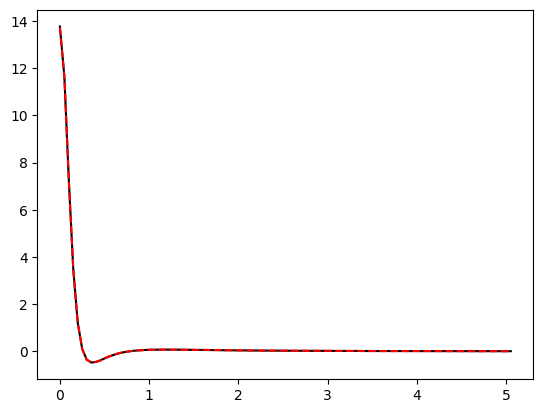

In [33]:
#and check the accuracy of the bath correlation function
plt.plot(t, np.real(bath.Ct(t)), 'k')
plt.plot(t, np.real(discbath.Ct(t)), 'r--')
plt.show()

### Setting up the System Information

Now we get the system information from the `pyttn.oqs.DiscreteBosonicBath` object, optionally applying mode combination to combine primitive bosonic modes into composite modes.

In [34]:
#set up the total system information object including both system information and bath information
#here the system consists of a single two level system
sysinf = pyttn.system_modes(1)
sysinf[0] = pyttn.tls_mode()

#truncate the bosonic modes to allow for a maximum energy of 10*wc and maximum number of excitations of 25, but a minimum number of 4
nbose = 40
discbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=nbose, Lmin=4))

use_mode_combination = True
if use_mode_combination:
    #here we allow for the combination of up to four modes provided the resultant composite Hilbert space dimension has size less than 1000
    nbmax=4
    nhilbmax=1000
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = discbath.system_information(mode_comb)
else:
    bsys = discbath.system_information()

#now combine the system and bath information together
sysinf = pyttn.combine_systems(sysinf, bsys)


### Building the Hamiltonian

In order to simplify construction of the discrete bath Hamiltonian, the discrete bath function contains the `add_system_bath_hamiltonian` and `system_bath_hamiltonian` functions that, respectively, append to the system-bath Hamiltonian terms to an existing `SOP` object or return a new `sSOP` object containing all system-bath Hamiltonian terms.  

In [35]:
#create the SOP object
H = pyttn.SOP(Nb+1)

#add on the system Hamiltonian
delta = 0.5
eps = 0
H += delta * pyttn.sOP("sx", 0) + eps * pyttn.sOP("sz", 0)

#and append all bath and system bath Hamiltonian terms
H = discbath.add_system_bath_hamiltonian(H, pyttn.sOP("sz", 0), geom="star")

Both the `add_system_bath_hamiltonian` and `system_bath_hamiltonian` objects can take a set of user defined indices corresponding to the bath modes (passed as the `binds` argument).  If this argument is not set, the function will assume that all bath modes are in a contiguous block starting at `bskip` which defaults to 1.  

Note: Care must be taken when defining the `binds` argument in conjunction with the use of mode_combination.  In the current release, pyTTN expects all composite modes to be formed of contiguous `primitive_modes`.

### Building the Wavefunction

We are now in a position to prepare the wavefunction tree topology.  Here, again, the `pyttn.oqs.DiscreteBosonicBath` class can help through the `add_bath_tree` function, which takes a node in an existing tree used to represent the system degrees of freedom and attaches either an MPS or balanced N-ary tree to represent the degrees of freedom handled by the discbath object.  

To build the tree, we first define the tree structure for system degrees of freedom, then attach the bath tree in the correct position.

In [36]:
#bond dimension used at start of simulation
chi0 = 4

#maximum allowed bond dimension in network
chi = 64

#the degree of the bath tree.  
#   degree=1 => MPS
#   degree>1 => balanced degree-ary tree
degree = 2

#set up the topology tree
topo = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(topo(), degree, chi0, chi0)

#set up the capacity tree
capacity = pyttn.ntree("(1(2(2)))")
_ = discbath.add_bath_tree(capacity(), degree, chi, chi)

Note: For the case we are considering here this inserts the bath nodes in such a way that they agree with the ordering in the Hamiltonian.  In general, the ordering of modes in the tree structure is determined by their traversal order using a pre-order depth-first search traversal.  For more complex use cases, it may become necessary to set the `system_modes.mode_indices` variable of the `sysinf` object that specifies how composite mode indices in the Hamiltonian in the Hamiltonian should be mapped to indices in the tree structure.


Now that we have constructed the tree topology, we can build the actually TTN wavefunction.  For standard OQS simulations, in which we perform dynamics from a state corresponding to an initially uncorrelated system-bath density operator, with a thermal (or vacuum) bath (dependent on temperature), the initial configuration of the bath for these unitary dynamics simulations is simply the vacuum state (at finite temperature this is due to the fact that we have used the thermofield mapping to construct a new model where the zero-temperature dynamics reproduces the finite-temperature dynamics of our original mode).  As such, creation of the initial wavefunction is straightfoward

In [37]:
#build the TTN object for this system
A = pyttn.ttn(topo, capacity, dtype=np.complex128)

#prepare a product state where the system is in the up spin state (0) and the bath is in its vacuum state
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state) 

### Preparing for Time Evolution

Now the final steps before preparing for the time-evolution are to:

1. set up time evolution parameters
2. construct the `sop_operator` representation.  Here we will use the hierarchical SOP representation of the Hamiltonian as it leads to considerable performance improvements compared to the SOP representation.
3. setup any observables of interest for the system.  Here, we will look at the magnetisation of the spin throughout the dynamics process, and so will set up a site_operator object to allow for evaluation of this quantity.
4. setup the `matrix_element` object used to evaluate expectation values.
5. create the `tdvp` object for time evolution.  Here we will use the adaptive one-site algorithm for time-evolution.

In [38]:
#set up the Hamiltonian as a sop_operator object
h = pyttn.sop_operator(H, A, sysinf)

#set up the observable to measure
op = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#construct matrix_element object need for evaluating observables
mel = pyttn.matrix_element(A)

#prepare the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim=16, subspace_neigs = 4, subspace_krylov_dim = 8, expansion='subspace')
sweep.spawning_threshold = 1e-8
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

### Performing the Time Evolution

Now that everything is set up we are in a position where we can perform each of the time-evolution steps and measure the observables of interest. 

 Here we make use of a little trick for improving the accuracy of the time-evolution at short time. For systems initially in the product state, the ttn wavefunction represents a rather constrained manifold, and the dynamics can depend strongly on the choice of initially unoccupied basis functions.  To alleviate this, it can be useful to perform small steps initially in order to allow for these unoccupied functions to evolve partially under the Hamiltonian of the system before too much damage has been done to the wavefunction.  As shown in Ref., this can dramatically improve the accuracy of the TDVP calculations with only very modest additional computational cost.

In [39]:
#measure the initial magnetisation
Sz[0] = np.real(mel(op, A, A))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]
i=1

Now that we have completed the first step, we return to time evolution as usual.

In [40]:
#set the values after the first timestep
Sz[i] =np.real(mel(op, A, A))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(op, A, A))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

And now that we have finished the time evolution we can plot the resultant magnetisation.

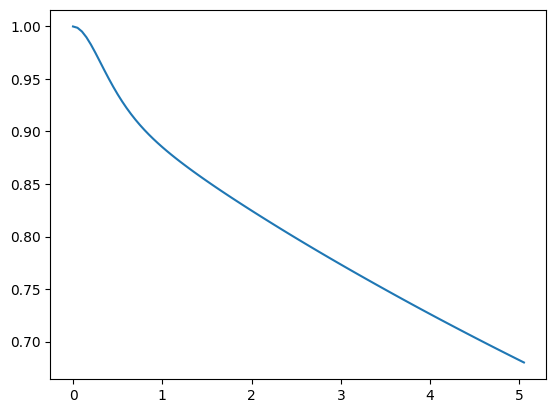

In [41]:
plt.plot(t, Sz)
plt.show()

And we can also do things like visualise how the bond dimension has expanded throughout the tensor network.

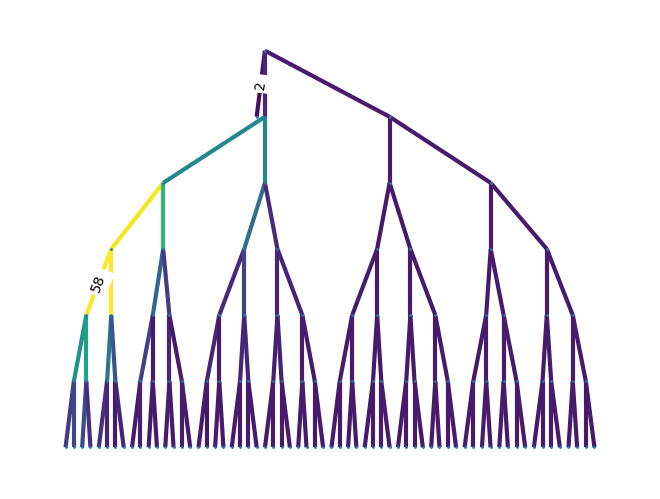

In [42]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

Where we observe that the required bond dimension varies considerably throughout the tree.  Here we note that the bath modes are ordered in increasing energy here.  Here we see that the largest bond dimensions necessary arise when accounting for the bath modes with frequencies:

In [43]:
print((w[0:8]))

[ 0.1298421  -0.50398813  0.80280349 -1.11818016  1.5163602  -1.70009323
 -2.24475598  2.26553747]
